In [29]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler, MinMaxScaler



# Set weights for feature combination

In [30]:

w1 = 0.7  # Weight for deep features
w2 = 0.3  # Weight for handcrafted features

# Path to Caltech-101 dataset
dataset_path = "/kaggle/input/caltech-101/caltech-101"

# Function to load images and labels
def load_data(dataset_path):
    images = []
    labels = []
    categories = os.listdir(dataset_path)
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(category)
    return np.array(images), np.array(labels)



# Load dataset

In [31]:

print("Loading dataset...")
images, labels = load_data(dataset_path)



Loading dataset...


# Encode labels

In [32]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)



# Preprocess images for VGG19

In [33]:

images = preprocess_input(images)



# Extract deep features using VGG19

In [34]:

def extract_deep_features(images):
    vgg19_model = VGG19(weights='imagenet', include_top=False, pooling='avg')
    features = vgg19_model.predict(images, verbose=1)
    return features

print("Extracting deep features...")
deep_features = extract_deep_features(images)



Extracting deep features...
286/286 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step


# Extract handcrafted features (ORB)

In [35]:

def extract_orb_features(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros(128)
    return descriptors.flatten()[:128]

print("Extracting handcrafted features...")
handcrafted_features = []
for img in images:
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
    handcrafted_features.append(extract_orb_features(gray))
handcrafted_features = np.array(handcrafted_features)



Extracting handcrafted features...


# Normalize features

In [36]:

scaler_deep = StandardScaler()
scaler_handcrafted = StandardScaler()
deep_features = scaler_deep.fit_transform(deep_features)
handcrafted_features = scaler_handcrafted.fit_transform(handcrafted_features)



# Reduce deep_features to match the dimensionality of handcrafted_features

In [37]:

pca_deep = PCA(n_components=128)
deep_features_reduced = pca_deep.fit_transform(deep_features)



# Combine features with weights

In [38]:

combined_features = w1 * deep_features_reduced + w2 * handcrafted_features



# Dimensionality reduction with PCA

In [39]:
# Dimensionality reduction with PCA
print("Applying PCA...")
pca = PCA(n_components=128)
combined_features_pca = pca.fit_transform(combined_features)



Applying PCA...


In [40]:
import matplotlib.pyplot as plt

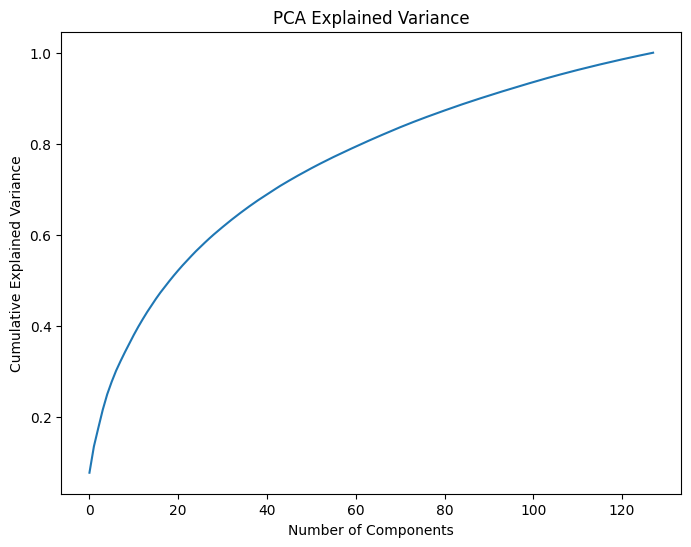

In [41]:
# Visualize PCA explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

# Optional: Dimensionality reduction with t-SNE

In [42]:

print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
combined_features_tsne = tsne.fit_transform(combined_features)



Applying t-SNE...


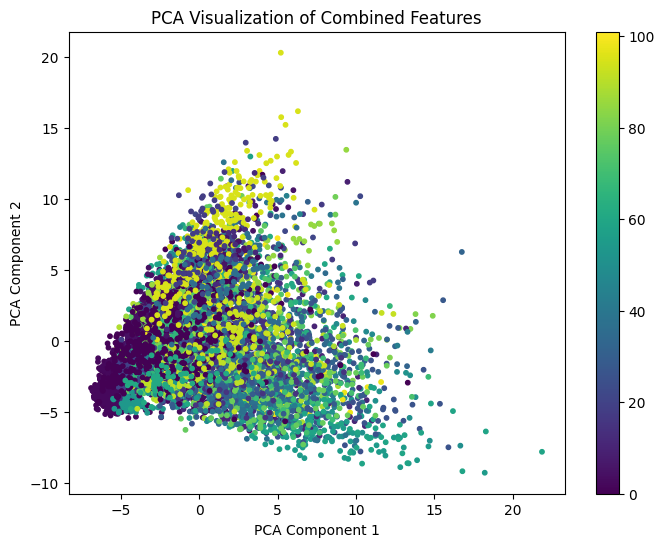

In [43]:
# Visualize the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(combined_features_pca[:, 0], combined_features_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Combined Features')
plt.show()

# Split dataset

In [44]:

X_train, X_test, y_train, y_test = train_test_split(combined_features_pca, labels, test_size=0.2, random_state=42)



# Train Random Forest Classifier

In [45]:

print("Training Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)



Training Random Forest Classifier...


RandomForestClassifier(random_state=42)

# Make predictions

In [46]:

y_pred = rf.predict(X_test)



# Evaluate model

In [47]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 80.59%


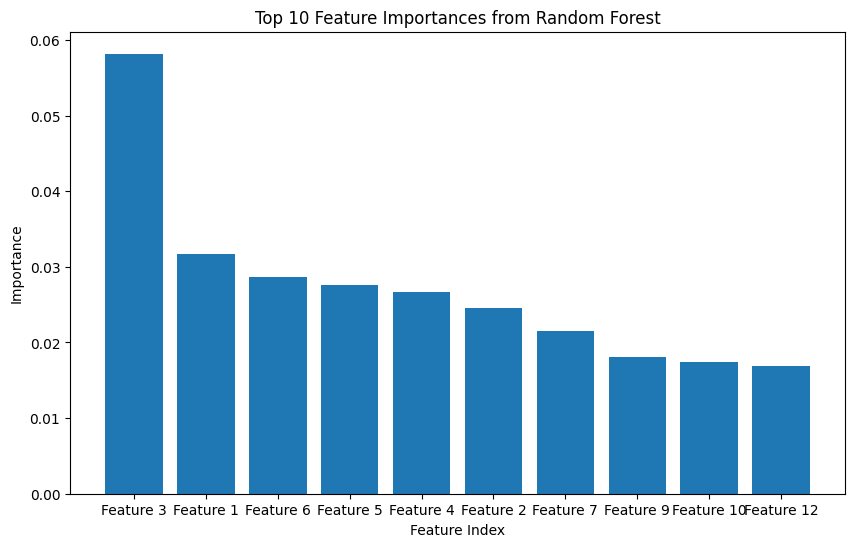

In [48]:
# Visualize feature importances from Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [f"Feature {i+1}" for i in indices[:10]])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()
